## In this notebook, we use Care for pair wise training. Q4.
## CM02: Q0_o, Q1_o, Q2_o, Q3_o, Q4_o, Q4_i, Q3_i, Q2_i, Q1_i, Q0_i
## CM03: Q0_i, Q1_i, Q2_i, Q3_i, Q4_i, Q4_o, Q3_o, Q2_o, Q1_o, Q0_o

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import glob
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
import copy


Using TensorFlow backend.


## Load Input and Output Data (jug-pc-1)

In [2]:
filenames = glob.glob("/home/lalit/Desktop/02_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

10
Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the -35:-28  z-slices as input from CM02

In [3]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][-35:-28, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(7, 896, 576)


## Take only the 28:35 z-slices as output from CM02

In [4]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][28:35, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(7, 896, 576)


## Load images from CM03 (jug-pc-1)

In [5]:
filenames = glob.glob("/home/lalit/Desktop/02_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the 28:35 z-slices from CM03 as input

In [6]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][28:35, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(7, 896, 576)


## Take only the -35:-28 z-slices from CM03 as output

In [7]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][-35:-28, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(7, 896, 576)


## Combine X_CM02 and X_CM03

In [8]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(7, 896, 576)


In [9]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(7, 896, 576)


## Visualize the images 

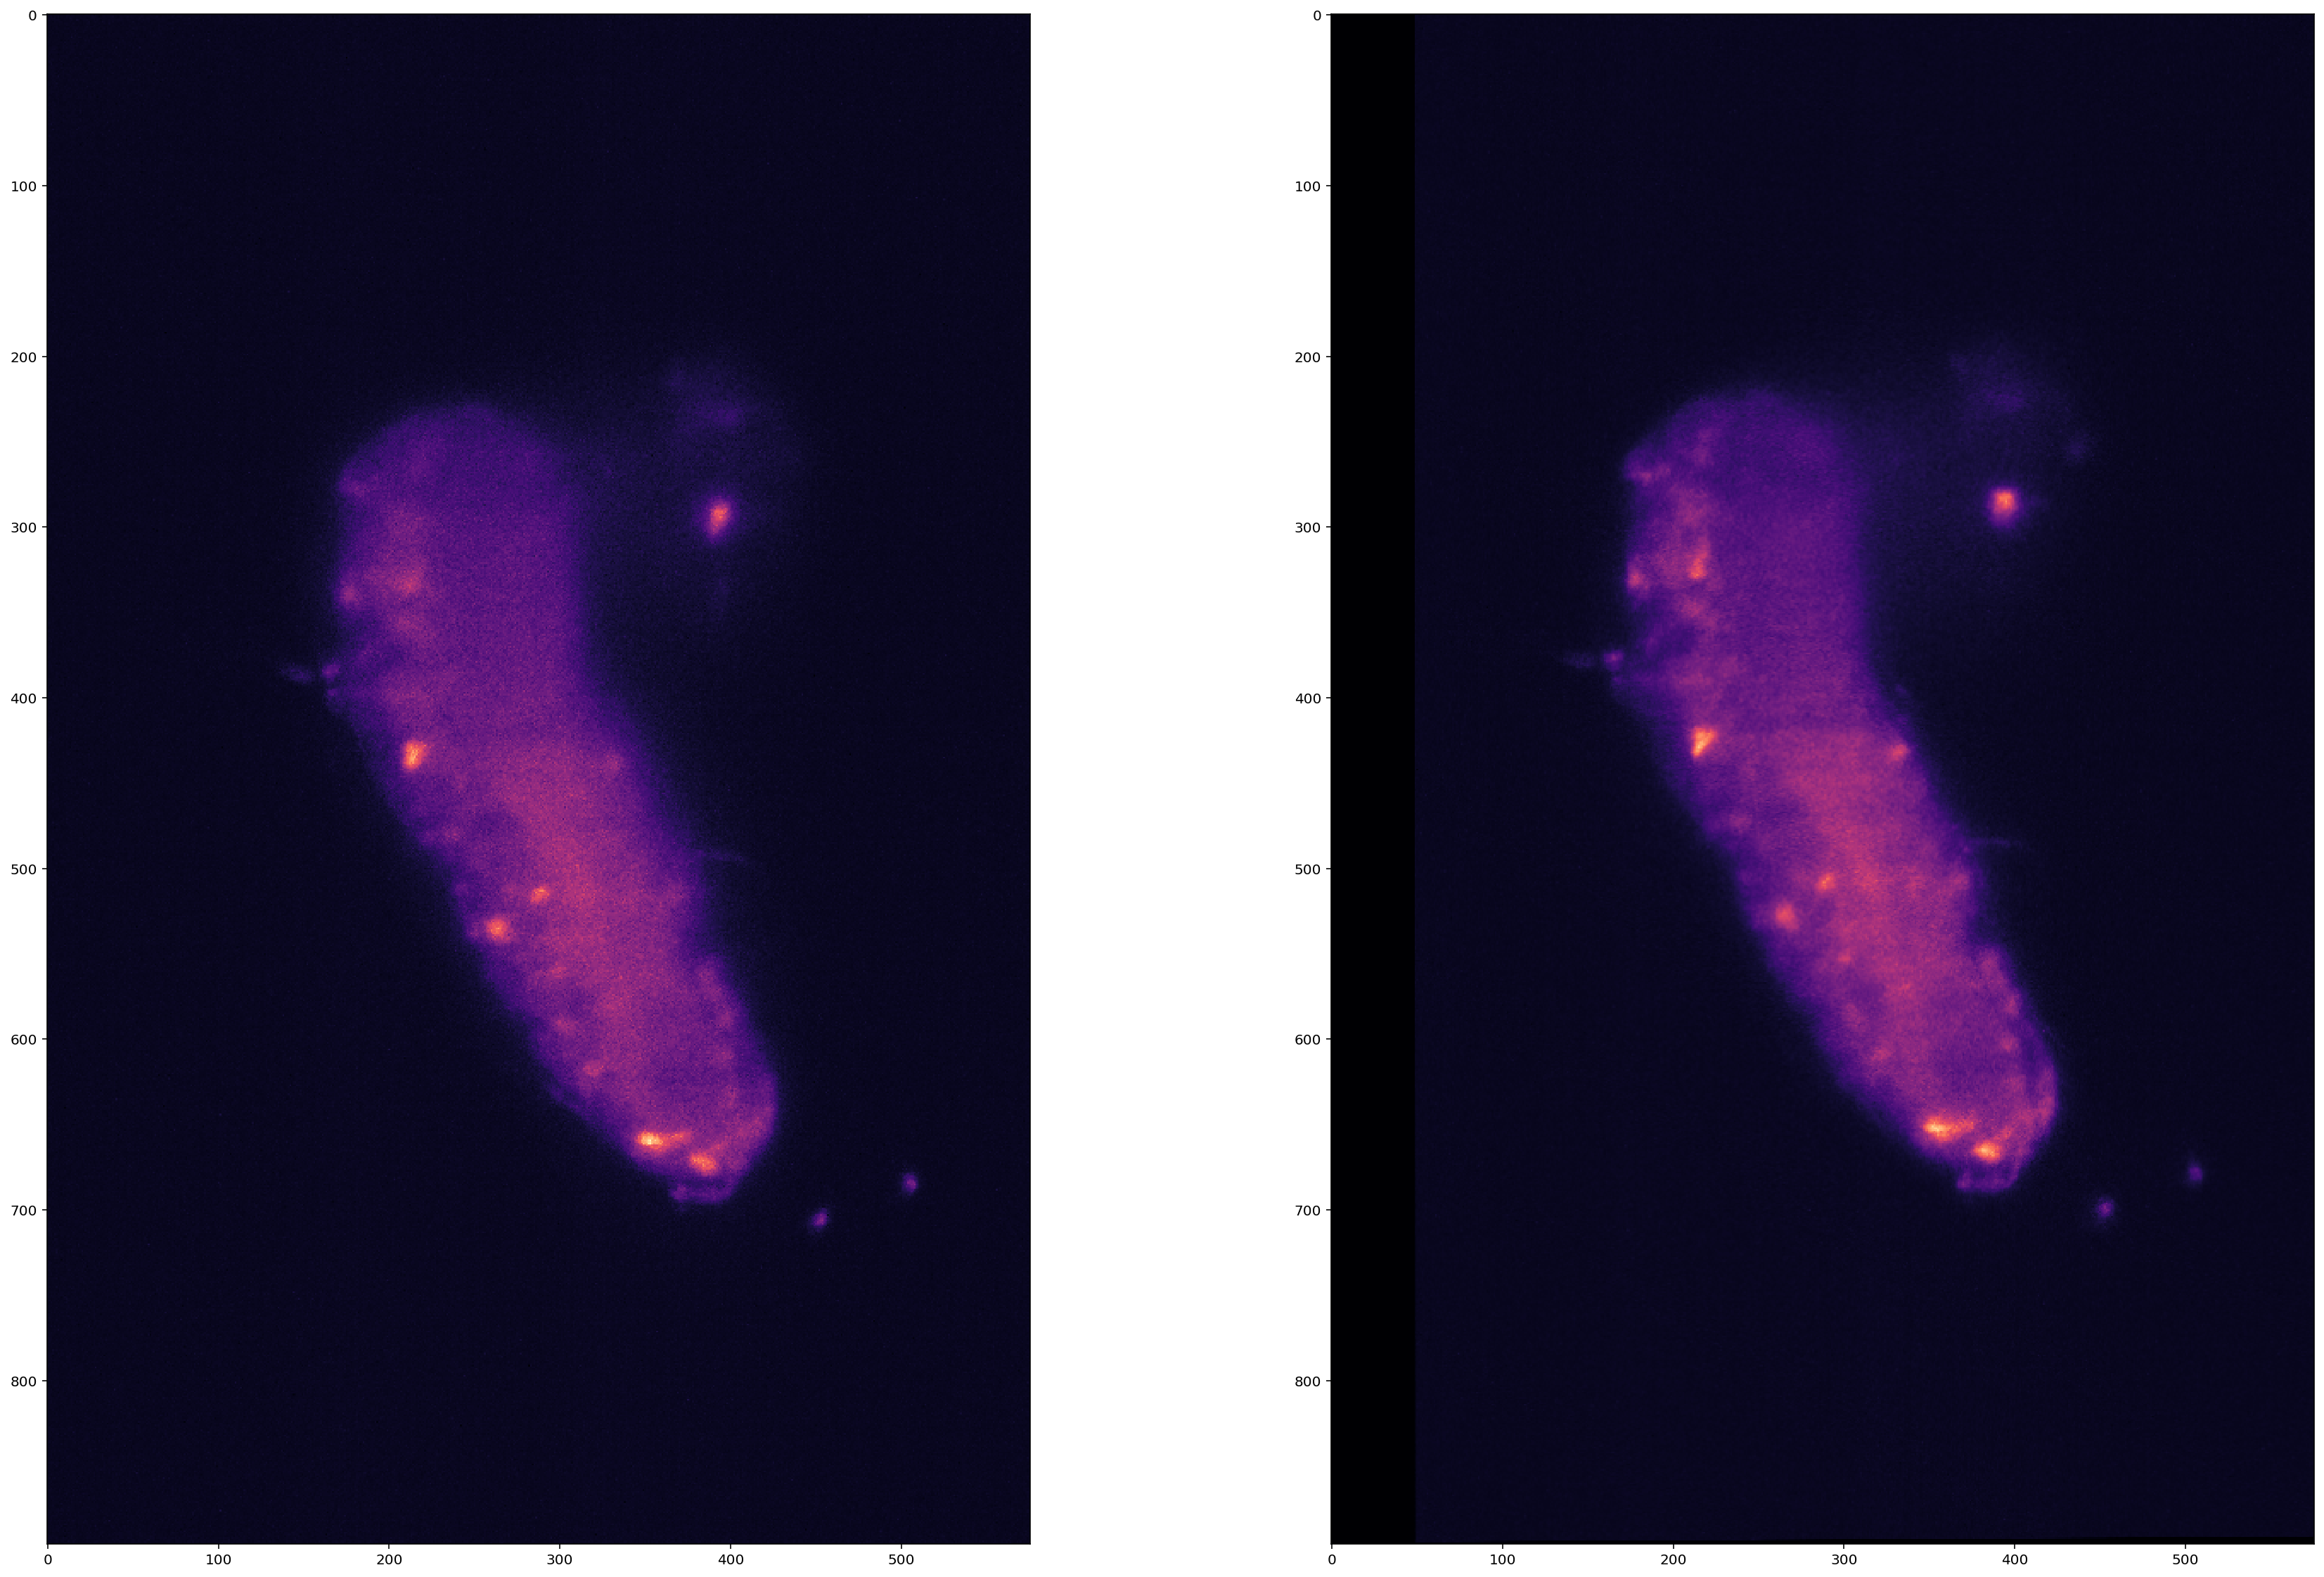

In [10]:
vmin=np.min(imgsX[14][5,...])
vmax=np.max(imgsX[14][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Since there is an artificial margin in the input and the output, we chop away the first and last 60 in the x dimension and in the y dimension

In [11]:
imgsX_chopped=[]
imgsY_chopped=[]
for i in range(len(imgsX)):
    imgsX_chopped.append(imgsX[i][:, 60:-60, 60:-60])
    imgsY_chopped.append(imgsY[i][:, 60:-60, 60:-60])

## Visualize the images again

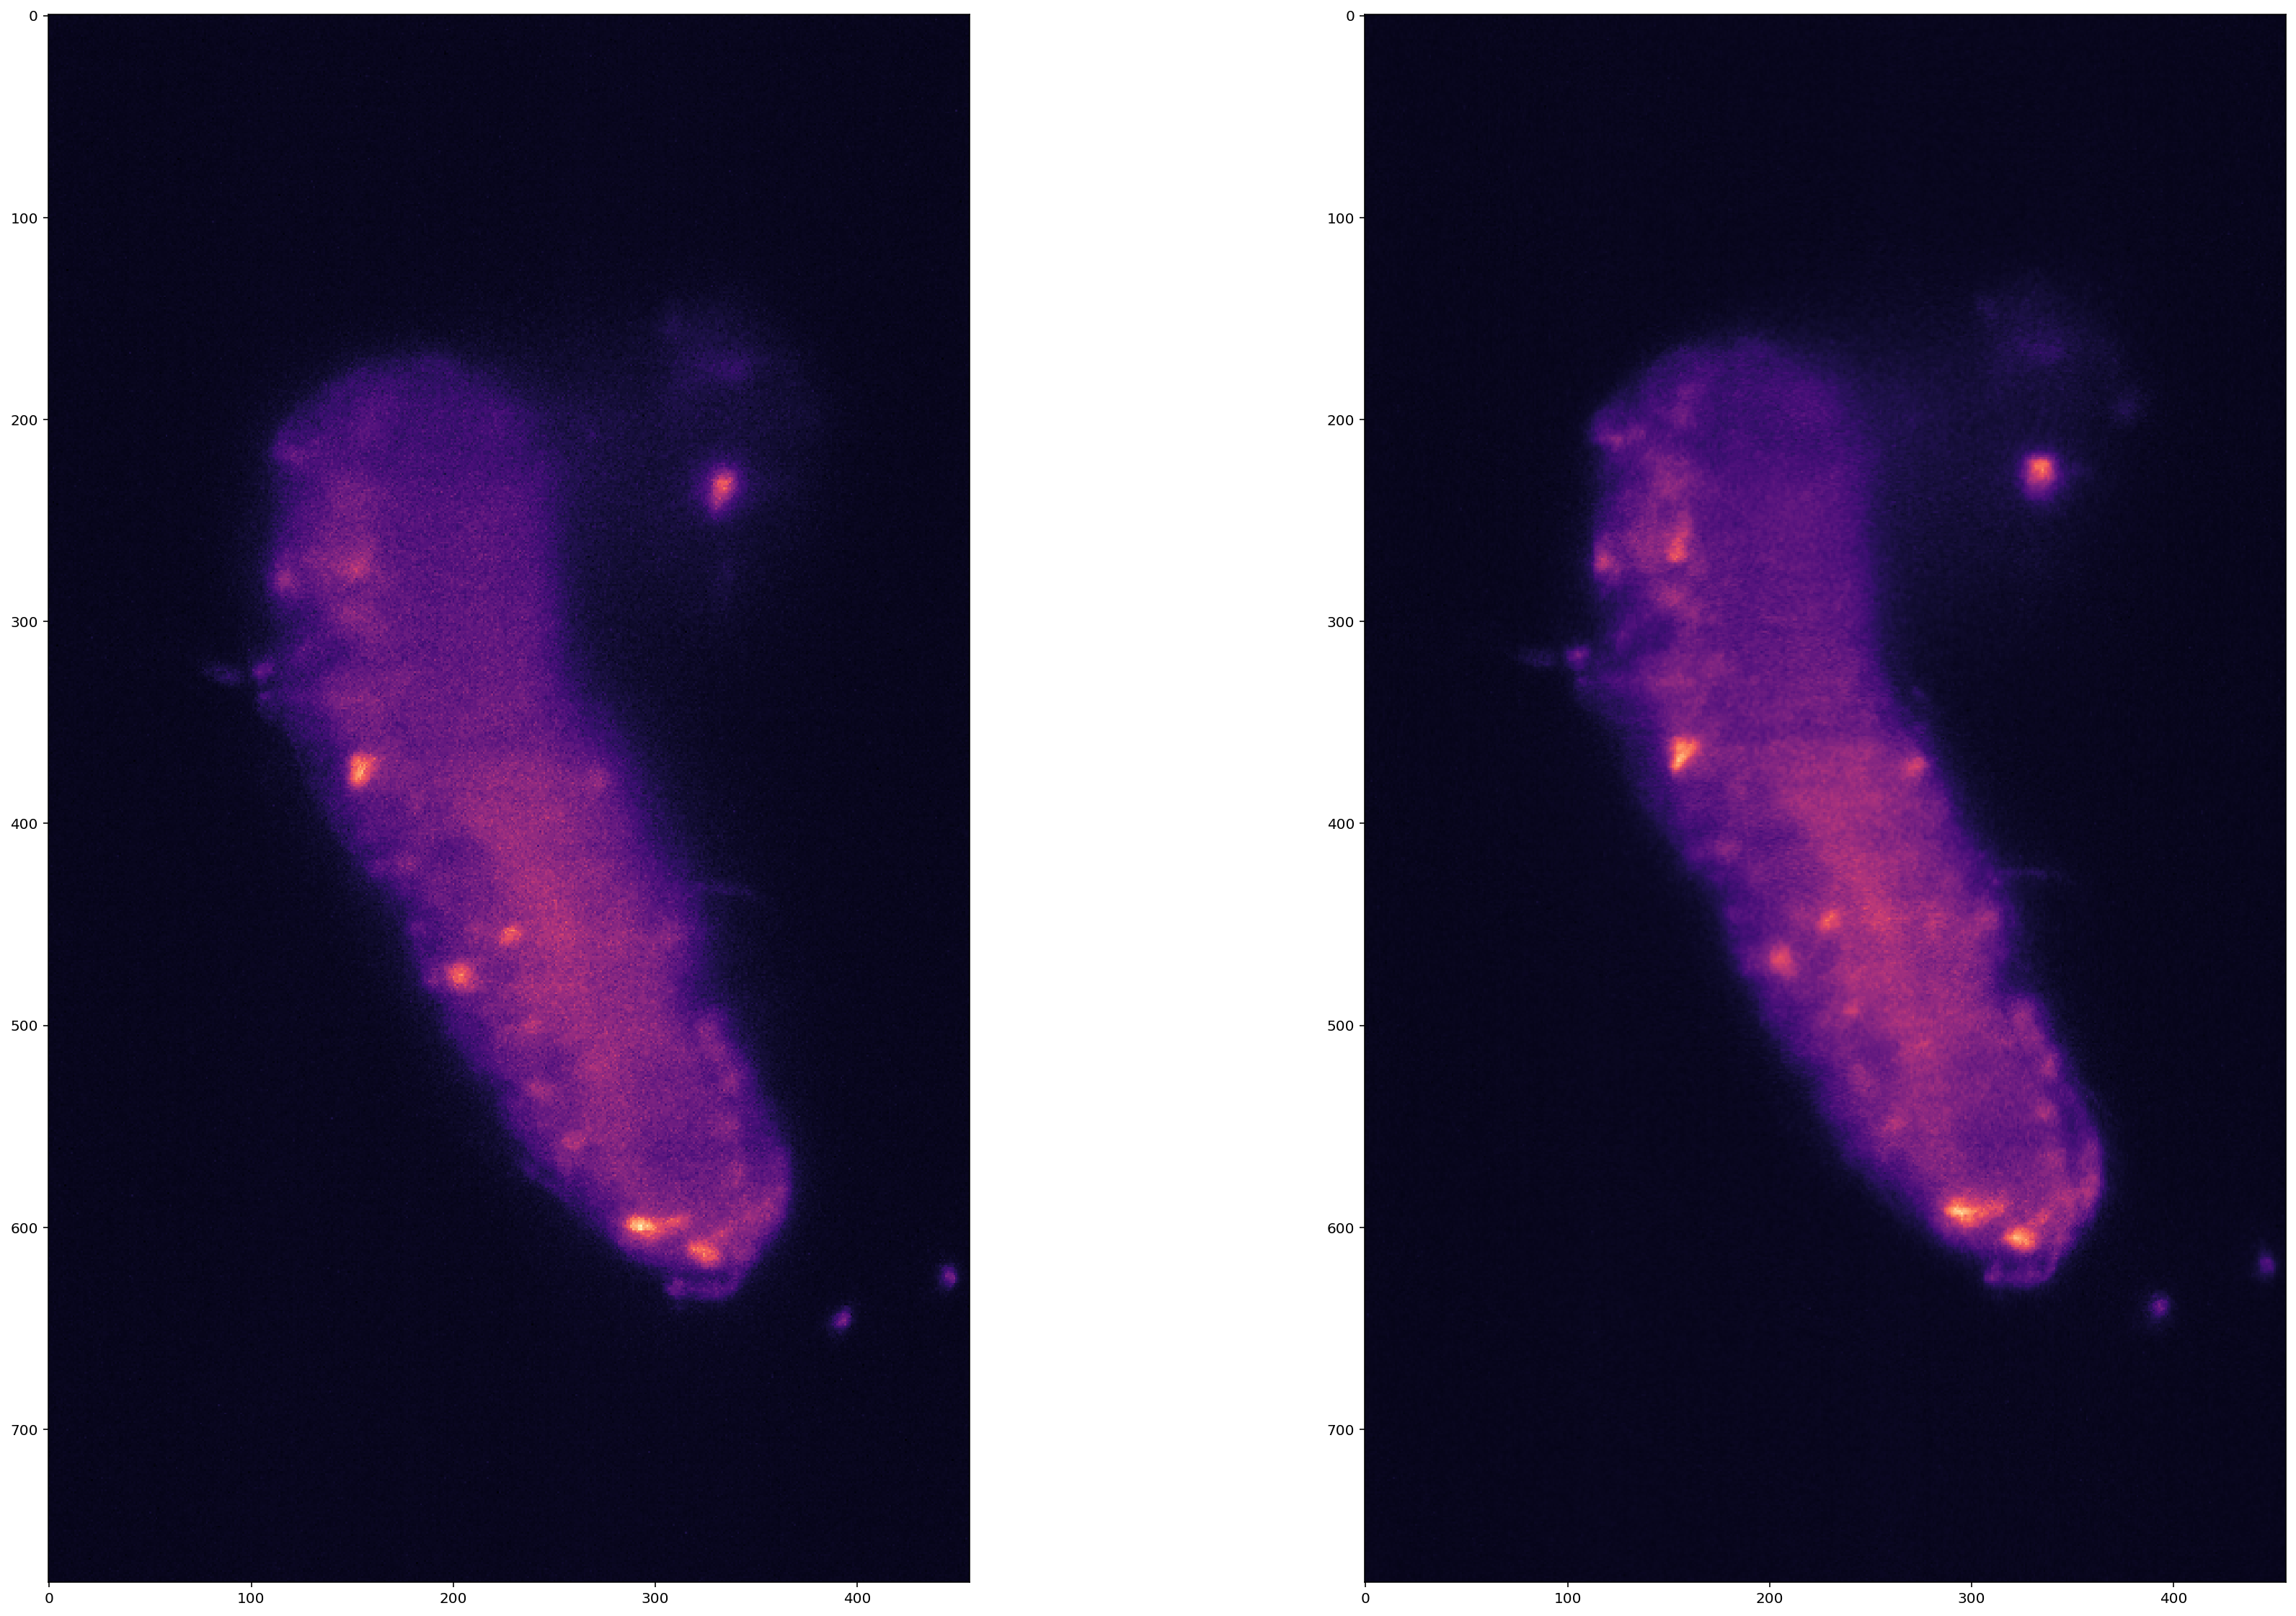

In [12]:
vmin=np.min(imgsX_chopped[15][5,...])
vmax=np.max(imgsX_chopped[15][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Also we must normalize the patches, prior to training !!

In [13]:
mean=np.mean(imgsX_chopped)
print(mean)
std=np.std(imgsX_chopped)
print(std)

130.2002369607976
58.090540553447575


## Create patches

In [14]:
imgsX_chopped=np.concatenate(imgsX_chopped, axis=0)
print(imgsX_chopped.shape)
imgsY_chopped=np.concatenate(imgsY_chopped, axis=0)
print(imgsY_chopped.shape)

(140, 776, 456)
(140, 776, 456)


In [15]:
combined=np.empty([np.shape(imgsX_chopped)[0], np.shape(imgsX_chopped)[1], np.shape(imgsX_chopped)[2], 2])
combined[..., 0]=imgsX_chopped
combined[..., 1]=imgsY_chopped
# Normalization Step
combined=(combined-mean)/std
print(combined.dtype)

float64


In [16]:
combinedList=[]
combinedList.append(combined)
print(len(combinedList))

1


## Augment is set to True

In [17]:
datagen = N2V_DataGenerator()
patches = datagen.generate_patches_from_list(combinedList, shape=(96, 96), augment=True)
print(patches.shape)

Generated patches: (35840, 96, 96, 2)
(35840, 96, 96, 2)


## Create train and validation pairs

In [18]:
X=patches[:-1000,..., 0]
X=X[..., np.newaxis]
Y=patches[:-1000, ..., 1]
Y=Y[..., np.newaxis]
X_val=patches[-1000:,..., 0]
X_val=X_val[..., np.newaxis]
Y_val=patches[-1000:, ..., 1]
Y_val=Y_val[..., np.newaxis]
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X shape:  (34840, 96, 96, 1)
Y shape:  (34840, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
Y_val shape:  (1000, 96, 96, 1)


In [19]:
print("Datatype is:", patches[0, ..., 0].dtype)

Datatype is: float64


## Plot some examples from validation data

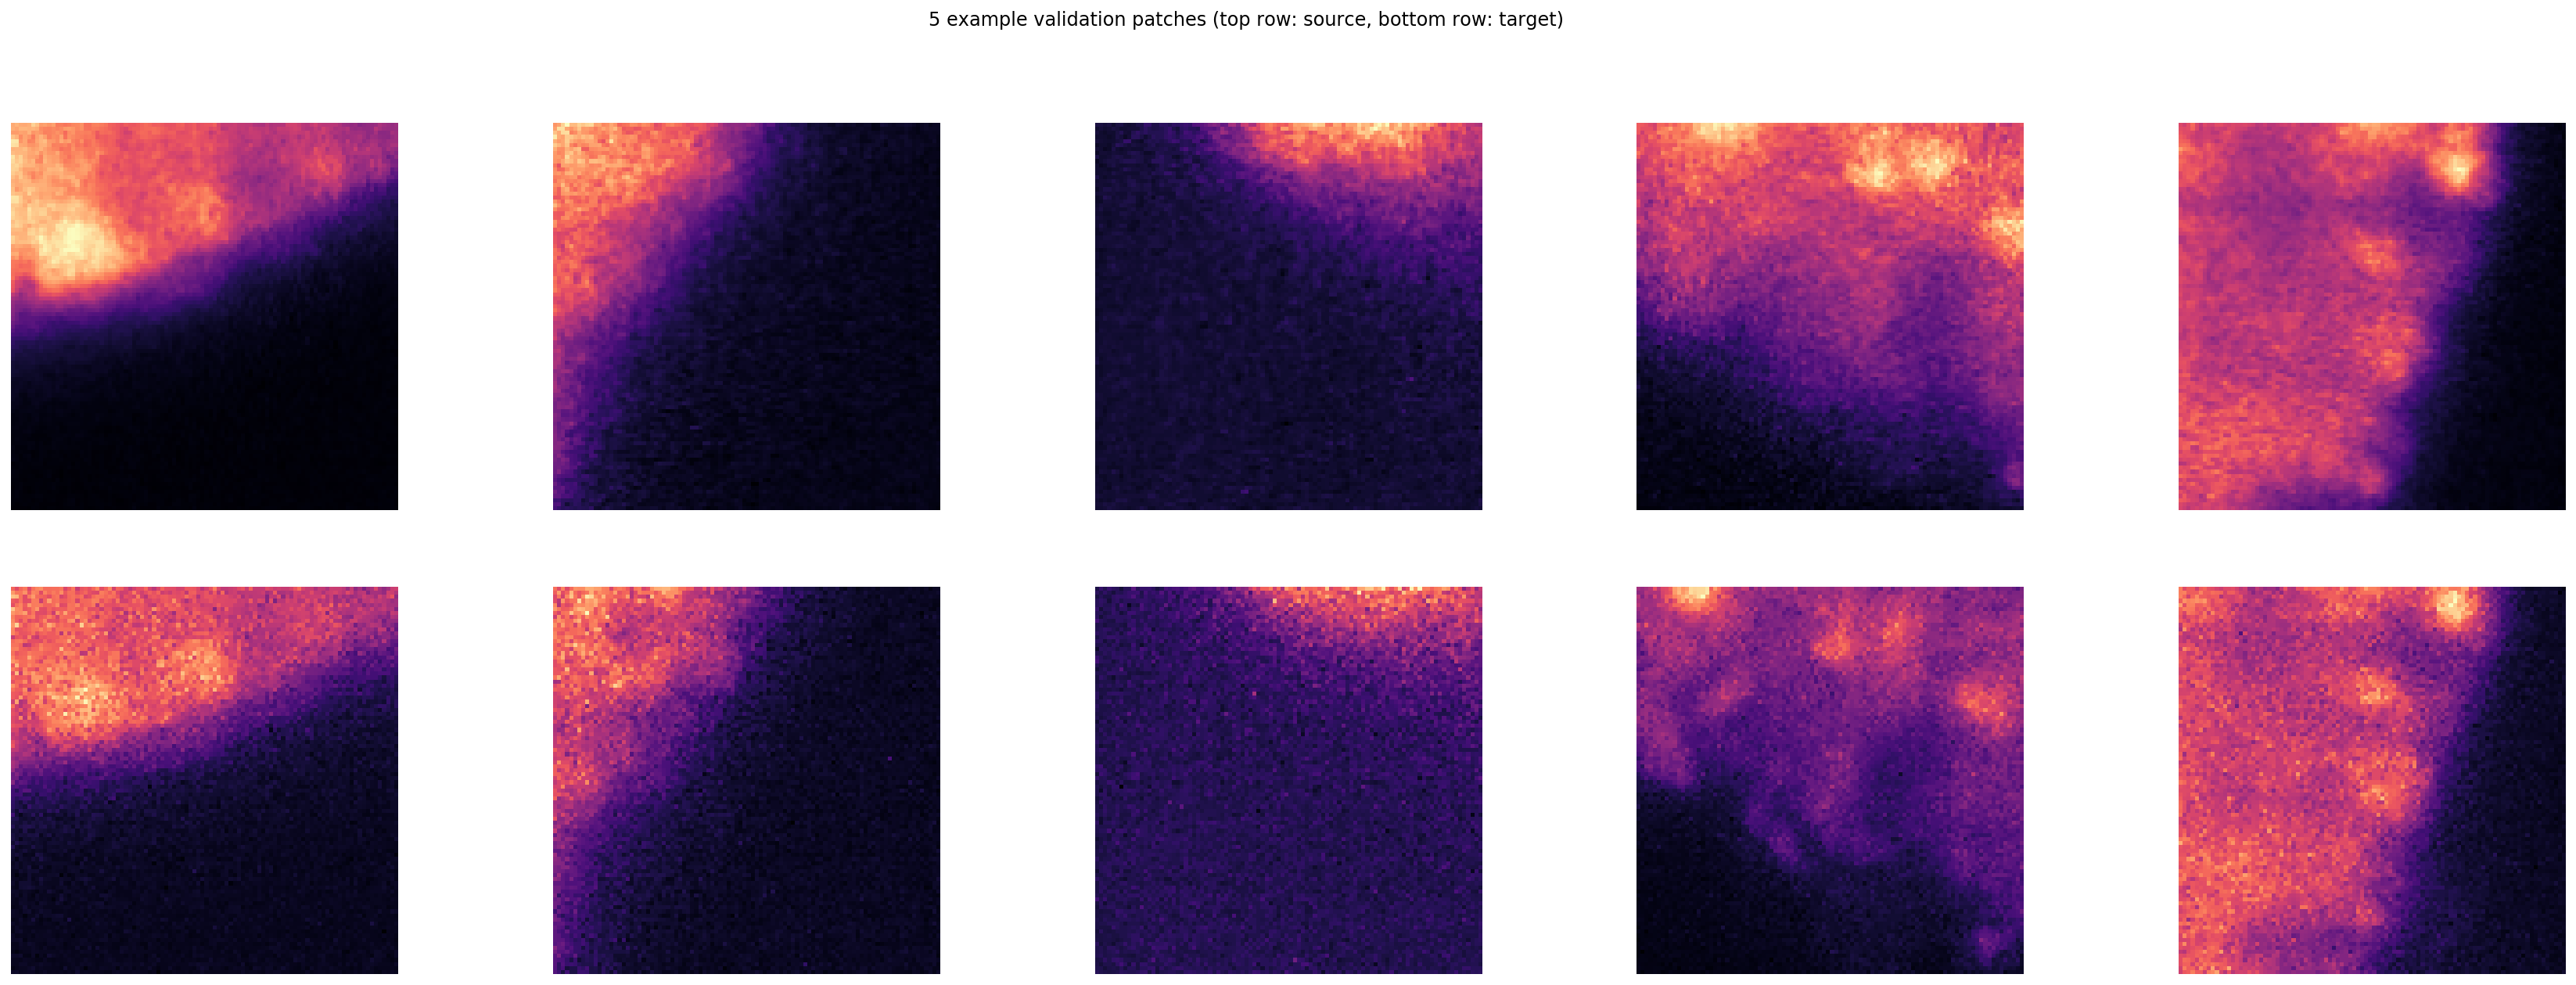

In [20]:
plt.figure(figsize=(30,10))
plot_some(X_val[300:305, ...],Y_val[300:305, ...])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [21]:
axes='SYXC'
n_channel_in=1
n_channel_out=1
config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=250, train_epochs=300, unet_n_first=64, unet_n_depth=3, unet_residual=False)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=300, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=250, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=64, unet_residual=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 300,
 'train_steps_per_epoch': 250,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [22]:
model = CARE(config, 'care_2D_kellerlab_with_normalization_with_HandRegistration_float64_Q4_ne_300_es_250', basedir='models')

In [23]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/home/lalit/Desktop/01_Softwares/anaconda3/envs/n2v368V2/lib/python3.6/site-packages/csbdeep/models/care_standard.py:259: UserWarning: small number of validation images (only 2.8% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))


Epoch 1/300
250/250 [==============================] - 25s 100ms/step - loss: 0.2207 - mse: 0.2784 - mae: 0.2207 - val_loss: 0.1834 - val_mse: 0.2452 - val_mae: 0.1834
Epoch 2/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1827 - mse: 0.2086 - mae: 0.1827 - val_loss: 0.1810 - val_mse: 0.2387 - val_mae: 0.1810
Epoch 3/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1810 - mse: 0.2193 - mae: 0.1810 - val_loss: 0.1775 - val_mse: 0.2372 - val_mae: 0.1775
Epoch 4/300
250/250 [==============================] - 23s 93ms/step - loss: 0.1810 - mse: 0.2139 - mae: 0.1810 - val_loss: 0.1764 - val_mse: 0.2363 - val_mae: 0.1764
Epoch 5/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1769 - mse: 0.2090 - mae: 0.1769 - val_loss: 0.1746 - val_mse: 0.2259 - val_mae: 0.1746
Epoch 6/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1748 - mse: 0.2072 - mae: 0.1748 - val_loss: 0.1732 - val_mse: 0.2214 - val_mae: 0.17

250/250 [==============================] - 23s 94ms/step - loss: 0.1542 - mse: 0.1596 - mae: 0.1542 - val_loss: 0.1613 - val_mse: 0.2032 - val_mae: 0.1613
Epoch 50/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1576 - mse: 0.1602 - mae: 0.1576 - val_loss: 0.1598 - val_mse: 0.2016 - val_mae: 0.1598
Epoch 51/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1556 - mse: 0.1730 - mae: 0.1556 - val_loss: 0.1618 - val_mse: 0.2099 - val_mae: 0.1618
Epoch 52/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1639 - mse: 0.1833 - mae: 0.1639 - val_loss: 0.1604 - val_mse: 0.1838 - val_mae: 0.1604
Epoch 53/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1522 - mse: 0.1571 - mae: 0.1522 - val_loss: 0.1613 - val_mse: 0.2067 - val_mae: 0.1613

Epoch 00053: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 54/300
250/250 [==============================] - 23s 93ms/step - loss: 0.1573 - mse: 

Epoch 97/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1536 - mse: 0.1473 - mae: 0.1536 - val_loss: 0.1556 - val_mse: 0.1839 - val_mae: 0.1556
Epoch 98/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1526 - mse: 0.1539 - mae: 0.1526 - val_loss: 0.1555 - val_mse: 0.1845 - val_mae: 0.1555
Epoch 99/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1492 - mse: 0.1461 - mae: 0.1492 - val_loss: 0.1556 - val_mse: 0.1841 - val_mae: 0.1556
Epoch 100/300
250/250 [==============================] - 23s 93ms/step - loss: 0.1503 - mse: 0.1539 - mae: 0.1503 - val_loss: 0.1564 - val_mse: 0.1877 - val_mae: 0.1564
Epoch 101/300
250/250 [==============================] - 25s 99ms/step - loss: 0.1537 - mse: 0.1558 - mae: 0.1537 - val_loss: 0.1558 - val_mse: 0.1847 - val_mae: 0.1558
Epoch 102/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1563 - mse: 0.1726 - mae: 0.1563 - val_loss: 0.1563 - val_mse: 0.1893 - val_m

250/250 [==============================] - 23s 94ms/step - loss: 0.1535 - mse: 0.1556 - mae: 0.1535 - val_loss: 0.1550 - val_mse: 0.1844 - val_mae: 0.1550
Epoch 146/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1527 - mse: 0.1563 - mae: 0.1527 - val_loss: 0.1552 - val_mse: 0.1849 - val_mae: 0.1552
Epoch 147/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1488 - mse: 0.1431 - mae: 0.1488 - val_loss: 0.1550 - val_mse: 0.1826 - val_mae: 0.1550
Epoch 148/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1560 - mse: 0.1661 - mae: 0.1560 - val_loss: 0.1549 - val_mse: 0.1806 - val_mae: 0.1549
Epoch 149/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1564 - mse: 0.1692 - mae: 0.1564 - val_loss: 0.1550 - val_mse: 0.1840 - val_mae: 0.1550
Epoch 150/300
250/250 [==============================] - 24s 95ms/step - loss: 0.1516 - mse: 0.1535 - mae: 0.1516 - val_loss: 0.1550 - val_mse: 0.1829 - val_mae: 0.1550


250/250 [==============================] - 24s 94ms/step - loss: 0.1461 - mse: 0.1412 - mae: 0.1461 - val_loss: 0.1544 - val_mse: 0.1809 - val_mae: 0.1544
Epoch 193/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1521 - mse: 0.1639 - mae: 0.1521 - val_loss: 0.1544 - val_mse: 0.1810 - val_mae: 0.1544
Epoch 194/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1464 - mse: 0.1415 - mae: 0.1464 - val_loss: 0.1545 - val_mse: 0.1822 - val_mae: 0.1545
Epoch 195/300
250/250 [==============================] - 23s 93ms/step - loss: 0.1479 - mse: 0.1401 - mae: 0.1479 - val_loss: 0.1545 - val_mse: 0.1819 - val_mae: 0.1545
Epoch 196/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1532 - mse: 0.1578 - mae: 0.1532 - val_loss: 0.1546 - val_mse: 0.1827 - val_mae: 0.1546
Epoch 197/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1500 - mse: 0.1495 - mae: 0.1500 - val_loss: 0.1545 - val_mse: 0.1814 - val_mae: 0.1545


Epoch 239/300
250/250 [==============================] - 23s 93ms/step - loss: 0.1511 - mse: 0.1480 - mae: 0.1511 - val_loss: 0.1545 - val_mse: 0.1815 - val_mae: 0.1545
Epoch 240/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1449 - mse: 0.1361 - mae: 0.1449 - val_loss: 0.1545 - val_mse: 0.1818 - val_mae: 0.1545
Epoch 241/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1490 - mse: 0.1427 - mae: 0.1490 - val_loss: 0.1545 - val_mse: 0.1816 - val_mae: 0.1545
Epoch 242/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1522 - mse: 0.1604 - mae: 0.1522 - val_loss: 0.1544 - val_mse: 0.1814 - val_mae: 0.1544
Epoch 243/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1551 - mse: 0.1609 - mae: 0.1551 - val_loss: 0.1544 - val_mse: 0.1811 - val_mae: 0.1544
Epoch 244/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1494 - mse: 0.1432 - mae: 0.1494 - val_loss: 0.1544 - val_mse: 0.1810 - va

250/250 [==============================] - 24s 94ms/step - loss: 0.1538 - mse: 0.1583 - mae: 0.1538 - val_loss: 0.1544 - val_mse: 0.1813 - val_mae: 0.1544
Epoch 286/300
250/250 [==============================] - 23s 93ms/step - loss: 0.1495 - mse: 0.1401 - mae: 0.1495 - val_loss: 0.1544 - val_mse: 0.1813 - val_mae: 0.1544

Epoch 00286: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 287/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1483 - mse: 0.1402 - mae: 0.1483 - val_loss: 0.1544 - val_mse: 0.1813 - val_mae: 0.1544
Epoch 288/300
250/250 [==============================] - 23s 93ms/step - loss: 0.1467 - mse: 0.1413 - mae: 0.1467 - val_loss: 0.1544 - val_mse: 0.1813 - val_mae: 0.1544
Epoch 289/300
250/250 [==============================] - 23s 94ms/step - loss: 0.1520 - mse: 0.1485 - mae: 0.1520 - val_loss: 0.1544 - val_mse: 0.1813 - val_mae: 0.1544
Epoch 290/300
250/250 [==============================] - 24s 94ms/step - loss: 0.1491 -

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


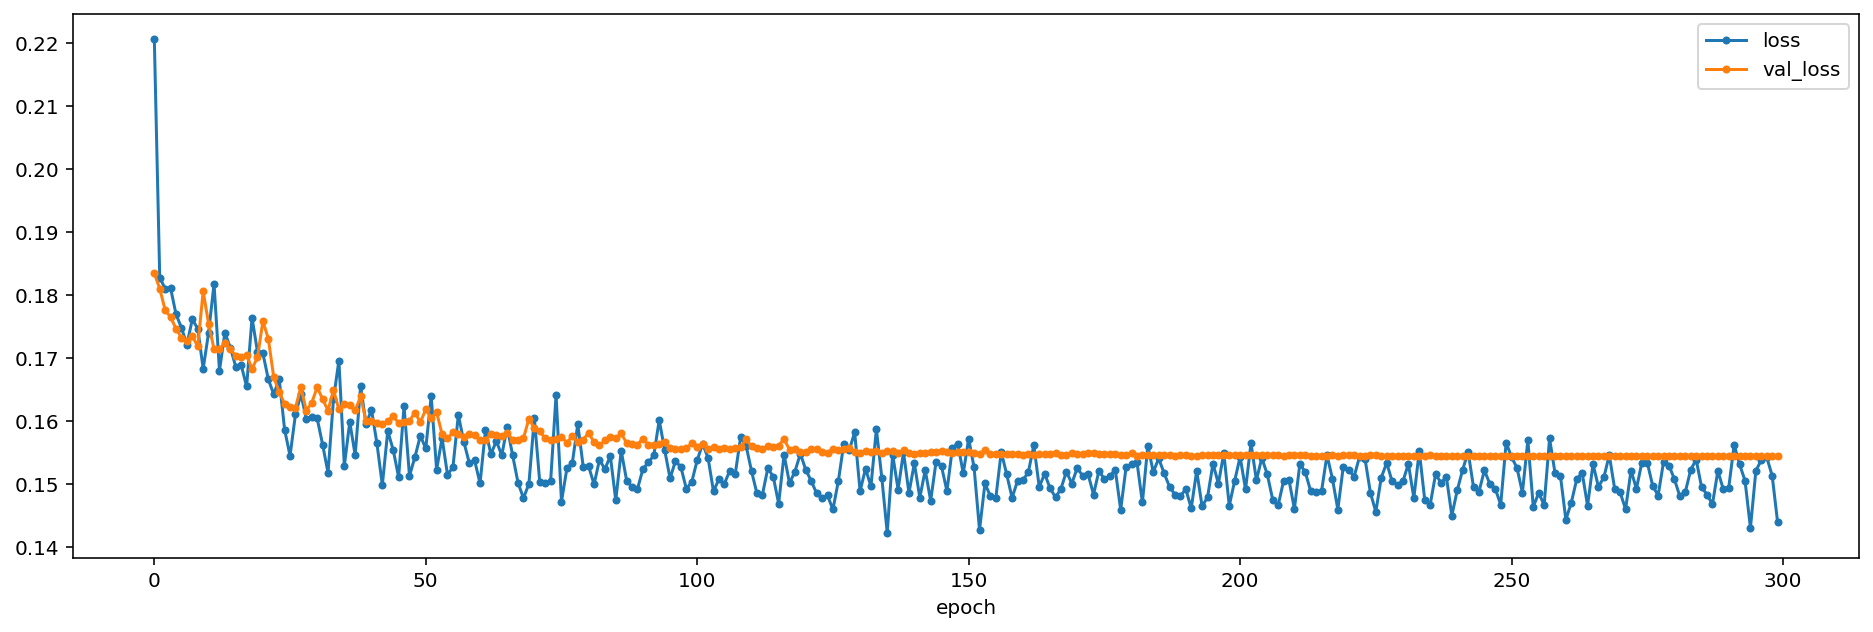

In [24]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);